In [1]:
import pandas as pd
import nltk
# Загружаем предобученную модель токенизации текста
nltk.download('punkt')
import csv
import os
import wget
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chern\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


##  Загрузка датасета новостей lenta.ru

In [3]:
# Загрузим датасет с новостями с lenta.ru
news = pd.read_csv('news_lenta_ru.csv', engine='python', on_bad_lines='skip')

In [4]:
news

,url,title,text,topic,tags
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая
...,...,...,...,...,...
9995,https://lenta.ru/news/2000/07/10/kpp/,На границе Дагестана и Чечни будут стрелять в ...,Глава МВД Дагестана приказал нарядам милиции н...,Россия,Все
9996,https://lenta.ru/news/2000/07/10/gossovet/,Путин пересадит губернаторов в Госсовет,Представители Кремля ведут активный диалог с г...,Россия,Все
9997,https://lenta.ru/news/2000/07/10/clowns/,В Москву съедутся клоуны со всего мира,"В Москве 20 июля открывается фестиваль ""Планет...",Россия,Все
9998,https://lenta.ru/news/2000/07/10/women/,Старшая Уильямс выигрывает чемпионский титул,Чисто американским получился финал Уимблдонск...,Спорт,Все


## Загрузка тонального словаря

In [5]:
# Датасет тонального словаря
url = 'https://raw.githubusercontent.com/dkulagin/kartaslov/master/dataset/kartaslovsent/kartaslovsent.csv'
path = 'kartaslovsent.csv'
if not os.path.isfile("kartaslovsent.csv"):
    # Загружаем данные
    wget.download(url, out=path)

In [7]:
df_tone_dictionary = pd.read_csv('kartaslovsent.csv', sep=';', on_bad_lines='skip')

In [8]:
df_tone_dictionary

,term,tag,value,pstv,ngtv,neut,dunno,pstvNgtvDisagreementRatio
0,абажур,NEUT,0.08,0.185,0.037,0.580,0.198,0.00
1,аббатство,NEUT,0.10,0.192,0.038,0.578,0.192,0.00
2,аббревиатура,NEUT,0.08,0.196,0.000,0.630,0.174,0.00
3,абзац,NEUT,0.00,0.137,0.000,0.706,0.157,0.00
4,абиссинец,NEUT,0.28,0.151,0.113,0.245,0.491,0.19
...,...,...,...,...,...,...,...,...
46122,ёмкость,NEUT,0.00,0.167,0.000,0.690,0.143,0.00
46123,ёрзать,NGTV,-0.54,0.050,0.446,0.397,0.107,0.00
46124,ёрничать,NGTV,-0.79,0.078,0.529,0.236,0.157,0.00
46125,ёрш,NEUT,0.16,0.224,0.072,0.576,0.128,0.00


## Перемешаем и разделим датафрейм на две части (1-разметка вручную, 2-разметка на основе правил)

In [9]:
title_news_1, title_news_2 = train_test_split(news['title'], train_size=5, random_state=42)

In [10]:
# Преобразуем полученые датасеты в датафреймы Pandas
df_title_news_1 = pd.DataFrame(title_news_1)
df_title_news_2 = pd.DataFrame(title_news_2)

In [11]:
df_title_news_1.head()

,title
5734,Ястржембский называет имя арестованного за взр...
5191,"Чемпионат Италии: ""Ювентус"" ушел в отрыв"
5390,Из Чернокозово отпущены первые амнистированные...
860,Парламент Украины затребовал у Конгресса США п...
7270,Пилот Формулы-1 уцелел в авиакатастрофе


In [12]:
df_title_news_2.head()

,title
6252,"Чтобы не платить налог, интернет-изданиям нужн..."
4684,Кубинского дипломата выставили из США
1731,Правительство РФ: третье тысячеление наступит ...
4742,Взрывчатку в Сибирь отправили по почте
4521,В Дагестане совершено покушение на генерала по...


## Определение функций

In [13]:
# Функция для присвоения метки настроения на основе наличия положительных или отрицательных слов
def get_sentiment(text, df_td=df_tone_dictionary):
    '''
    Функция вычисляет метрику настроения.

    :param text: текст который будем анализировать,
    :param df_td: тональный словарь,
    :return: возвращает оценку тональности: -0.35 (неготив) <= нейтрально >= (0.55) позитив 
    '''
    # Токенизация текста на отдельные слова
    words = nltk.word_tokenize(text.lower())
    sum_value = 0  # Сумма всех зачений весов найденных слов
    
    for word in words:
        if len(df_td[df_td.term == word]):
            df_filtered = df_td[df_td['term'] == word]
            value = df_filtered['value'].iloc[0]
            sum_value += value
 
    return sum_value   

In [14]:
# Определение функции для присвоения метки настроения на основе оценки полярности настроения
def get_sentiment_label(score):
    '''
    Функция выводит метку настроения (негативный, позитивный или нейтральный).

    :param score: уровень метки настроения от -1 до 1,
    :return: возвращает оценку тональности. 
    '''
    if score < -0.35:
        return 'negative'  
    elif score >= 0.55:
        return 'positive' 
    else:
        return 'neutral'

### Проверка функций

In [15]:
%%time
get_sentiment('Превосходно, что Аист прелетел')

CPU times: total: 15.6 ms
Wall time: 45.7 ms


0.55

In [16]:
get_sentiment('Удар молнии')

-0.68

In [17]:
get_sentiment('Всё в норме')

0

In [18]:
get_sentiment_label(get_sentiment('Превосходно, что Аист прелетел'))

'positive'

In [19]:
get_sentiment_label(get_sentiment('Удар молнии'))

'negative'

## Присваиваем метки
### Присвоение меток настроения на основе правил

In [20]:
%%time
# Применение функции к столбцу 'title' датасета для получения полярности настроения каждого заголовка новости
df_title_news_2['sentiment'] = df_title_news_2['title'].apply(get_sentiment)
# Применение функции к столбцу 'sentiment' датасета для присвоения меток настроения
df_title_news_2['sentiment_label'] = df_title_news_2['sentiment'].apply(get_sentiment_label)

CPU times: total: 1min 29s
Wall time: 3min 49s


In [21]:
df_title_news_2.head()

,title,sentiment,sentiment_label
6252,"Чтобы не платить налог, интернет-изданиям нужн...",-0.26,neutral
4684,Кубинского дипломата выставили из США,0.00,neutral
1731,Правительство РФ: третье тысячеление наступит ...,-0.14,neutral
4742,Взрывчатку в Сибирь отправили по почте,0.00,neutral
4521,В Дагестане совершено покушение на генерала по...,-1.00,negative


In [22]:
df_title_news_2.shape

(9995, 3)

### Присвоение меток настроения в label-studio

In [23]:
# Сохраним датафрем в CSV файл
df_title_news_1.to_csv('manual_marking.csv', index=False)

In [24]:
# Запускаем локально label-studio
!label-studio

^C


## Экспортируем размеченный вручную CSV файл и загружаем его в датафрейм

In [40]:
df_title_news_1 = pd.read_csv('project-1-at-2024-05-27-00-19-3822a918.csv', engine='python', on_bad_lines='skip')

In [41]:
df_title_news_1.head()

,annotation_id,annotator,created_at,id,lead_time,sentiment,title,updated_at
0,1,1,2024-05-27T00:08:25.109948Z,1,18.735,positive,Ястржембский называет имя арестованного за взр...,2024-05-27T00:08:33.034497Z
1,2,1,2024-05-27T00:09:05.374325Z,2,13.131,neutral,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",2024-05-27T00:17:06.400265Z
2,3,1,2024-05-27T00:09:26.498394Z,3,6.770,negative,Из Чернокозово отпущены первые амнистированные...,2024-05-27T00:09:26.498394Z
3,4,1,2024-05-27T00:09:59.909605Z,4,7.341,neutral,Парламент Украины затребовал у Конгресса США п...,2024-05-27T00:09:59.909605Z
4,5,1,2024-05-27T00:10:25.863949Z,5,4.486,positive,Пилот Формулы-1 уцелел в авиакатастрофе,2024-05-27T00:10:25.863949Z


In [42]:
# Оставим только нужные столбцы
df_title_news_1 = df_title_news_1[['title', 'sentiment']].rename(columns={'sentiment': 'sentiment_label'})

In [43]:
df_title_news_1.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,positive
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",neutral
2,Из Чернокозово отпущены первые амнистированные...,negative
3,Парламент Украины затребовал у Конгресса США п...,neutral
4,Пилот Формулы-1 уцелел в авиакатастрофе,positive


### Объединение датафреймов

In [44]:
# Объеденим три датафрейма
df_title_news_concat = pd.concat([
    df_title_news_1,
    df_title_news_2,
], axis=0)
# Удалим лишний столбец
del df_title_news_concat['sentiment']

In [45]:
df_title_news_concat.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,positive
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",neutral
2,Из Чернокозово отпущены первые амнистированные...,negative
3,Парламент Украины затребовал у Конгресса США п...,neutral
4,Пилот Формулы-1 уцелел в авиакатастрофе,positive


In [46]:
df_title_news_concat.shape

(10000, 2)

<Axes: >

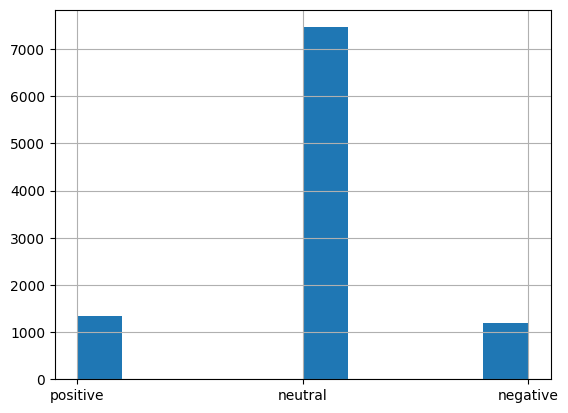

In [47]:
# Выведем график тональности заголовков новостей
df_title_news_concat['sentiment_label'].hist()

In [48]:
# Статистика тональности заголоаков новостей
df_title_news_concat.groupby(['sentiment_label']).agg({'sentiment_label': ['count']})

,sentiment_label
,count
sentiment_label,
negative,1186
neutral,7463
positive,1351


### Обучение модели

In [49]:
le = LabelEncoder()
# Преобразуем в датафрейме буквеное обозначение в цифровое
df_title_news_concat['sentiment_label'] = le.fit_transform(df_title_news_concat['sentiment_label'].astype(str))

In [50]:
df_title_news_concat.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,2
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",1
2,Из Чернокозово отпущены первые амнистированные...,0
3,Парламент Украины затребовал у Конгресса США п...,1
4,Пилот Формулы-1 уцелел в авиакатастрофе,2


In [51]:
# Перемешивание данных
df_title_news_concat = shuffle(df_title_news_concat)

In [52]:
# Разделение датасета на размеченную и неразмеченную выборки
labeled_title, unlabeled_title = train_test_split(df_title_news_concat, train_size=0.2, random_state=42)

In [53]:
labeled_title.head()

,title,sentiment_label
7527,Ford сокращает две тысячи рабочих мест в Европе,1
6118,В пригороде Осло загорелся товарный состав с п...,1
2273,Ельцин лично позвонил Лукашенко,1
752,"В Уфе выпустили водку ""Беспохмельную""",1
1492,Места в избирательном бюллетене разыграли на л...,1


In [54]:
unlabeled_title.head()

,title,sentiment_label
6361,"ОПЕК сократит добычу нефти, если цена за барре...",1
2551,Новый программный продукт позволяет эффективно...,2
8172,В федеральных округах создадут представительст...,1
3486,В Москве убит администратор Центральной хораль...,1
3300,Самолет с нефтяниками рухнул в море у берегов ...,1


In [55]:
# Определение функции для обучения модели логистической регрессии на размеченных данных
def train_model(labeled_title):
    # Векторизация текстовых данных с помощью TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(labeled_title['title'])
    y = labeled_title['sentiment_label']

    # Обучение модели логистической регрессии на размеченных данных
    model = LogisticRegression()
    model.fit(X, y)

    return model, vectorizer

In [56]:
# Обучение начальной модели на небольшом наборе 
model, vectorizer = train_model(labeled_title)

In [57]:
# Использование исходной модели для прогнозирования настроения неразмеченных данных
X_unlabeled = vectorizer.transform(unlabeled_title['title'])
y_unlabeled_predicted = model.predict(X_unlabeled)

In [58]:
# Вычисление неопределенности или энтропии предсказаний
y_unlabeled_proba = model.predict_proba(X_unlabeled)
uncertainty = -(y_unlabeled_proba * np.log2(y_unlabeled_proba)).sum(axis=1)

In [59]:
# Выбор 100 наиболее неопределенных точек данных для маркировки человеком
labeled_title_new = unlabeled_title.iloc[uncertainty.argsort()[:100]]
unlabeled_title_new = unlabeled_title.iloc[uncertainty.argsort()[100:]]

In [60]:
labeled_title_new

,title,sentiment_label
2196,Путин выгонит торговцев из бомбоубежищ,1
76,Полностью вытеснить боевиков из Карамахи так и...,1
9107,Из окна школьного кабинета увидели бомбу,1
5544,Предварительные результаты выборов снова приду...,1
5615,Контрабанда нефти из Ирака достигла рекордного...,0
...,...,...
4999,Ястржембский опроверг информацию о захвате бое...,1
2057,РАО ЕЭС не боится 2000 года,1
1450,Из Гудермеса изгоняют ваххабитов?,1
5496,Гелаев ушел из Комсомольского неделю назад?,1


In [61]:
# Разметка новых точек данных и добавление их к размеченному множеству
labeled_title = pd.concat([labeled_title, labeled_title_new])

In [62]:
labeled_title.shape

(2100, 2)

In [63]:
unlabeled_title_new.shape

(7900, 2)

In [64]:
# Переобучение модели на расширенном маркированном множестве
model, vectorizer = train_model(labeled_title)

### Оценка обучения модели

In [65]:
# Загружаем тестовый датасет
title_test = pd.read_csv('test.csv', engine='python', on_bad_lines='skip')

In [66]:
# Преобразуем в датафрейме буквенное обозначение в цифровое
title_test['sentiment_label'] = le.fit_transform(title_test['sentiment_label'].astype(str))

In [67]:
title_test.head()

,title,sentiment_label
0,Вагоны московского метро будут складываться га...,1
1,В Чечню пытались проникнуть наемники из Пакистана,1
2,Таллинские заключенные предпочитают голод духоте,0
3,"Адвокатам ""Моста"" не удалось дать отвод следов...",1
4,В поезде Донецк-Москва нашли взрывчатку,1


In [68]:
# Оценка модели на тестовом датасете
X_test = vectorizer.transform(title_test['title'])
y_test_predicted = model.predict(X_test)
f1 = f1_score(title_test['sentiment_label'], y_test_predicted, average='micro')

print(f1)

0.83948


## Вывод:

При выполнии разметки выбранного подмножества на основе правил, разметки вручную другого подмножества и объединии двух выборок в один дасет, а также обучении модели эффективность обученной модели составила 84%. Разметка на основе правил существенно экономит трудозатраты.